In [1]:
import numpy as np
from scipy import interpolate
import pyhmcode
import pyhmcode.halo_profile_utils
import pyccl
import matplotlib.pyplot as plt

Here I define the cosmology via CCL, this is used to compute the linear power spectrum which is feeded into HM-code.

In [2]:
Omega_c=0.25 # cold dark matter density today
Omega_b=0.05 # baryon density today
h=0.7 # Hubble constant
n_s=0.963 # spectra index of the primordial matter power spectrum
sigma8=0.834 # normalization of the matter power spectrum 
w0=-1 # equation of state parameter of dark energy w(a) = w0 + (1-a)w_a
wa=0 
Neff=3.0446 # effective relativistic degrees of freedom 
log10Theat = 7.8 # AGN temperature for feedback 
m_nu= 0.05 # sum of neutrino masses in eV
m_nu_type = 'single'
transfer_function='boltzmann_camb'
ccl_cosmology = pyccl.Cosmology(Omega_c=Omega_c, Omega_b=Omega_b, h=h, n_s=n_s, sigma8=sigma8, w0=w0,wa=wa, Neff=Neff)
# ccl_cosmology = pyccl.Cosmology(Omega_c=Omega_c, Omega_b=Omega_b,
                                # h=h, n_s=n_s, sigma8=sigma8, w0=w0,wa=wa, Neff=Neff, 
                                # m_nu= m_nu, m_nu_type = m_nu_type, transfer_function=transfer_function)

In [3]:
zet_min = 1e-2
zet_max = 4
N_z_interp = 50
zet_interp = np.geomspace(
            zet_min,
            zet_max,
            N_z_interp)
kmin = 1e-5
kmax = 10
N_k = 300
k_vector_over_times_h = np.geomspace(kmin, kmax, N_k)
power = np.zeros((len(zet_interp), len(k_vector_over_times_h)))
power_matter = np.zeros((len(zet_interp), len(k_vector_over_times_h)))
        

for z_idx, z_val in enumerate(zet_interp):
    power[z_idx, :] = ccl_cosmology.linear_matter_power(k_vector_over_times_h*h,1.0/(1+z_val))*h**3
    power_matter[z_idx, :] = power[z_idx, :]/k_vector_over_times_h**4

I calculate the power spectra for the free gas and for matter (pyhmcode.field_gas and pyhmcode.field_matter respectively). I then use that we would define the bias as
$$ b^2_\mathrm{e}(k,z) =\frac{P_{\mathrm{ee}}(k,z)}{P_{\mathrm{mm}}(k,z)}. $$

In [4]:
hmcode_cosmology = pyhmcode.halo_profile_utils.ccl2hmcode_cosmo(
                        ccl_cosmo=ccl_cosmology,
                        pofk_lin_k_h=k_vector_over_times_h,
                        pofk_lin_z=zet_interp,
                        pofk_lin=power,
                        log10_T_heat=log10Theat)
hmcode_model = pyhmcode.Halomodel(
            pyhmcode.HMx2020_matter_pressure_w_temp_scaling)
hmcode_pofk = pyhmcode.calculate_nonlinear_power_spectrum(
                            cosmology=hmcode_cosmology,
                            halomodel=hmcode_model, 
                            fields=[pyhmcode.field_matter,
                                    pyhmcode.field_gas])
bias_sq = np.copy(hmcode_pofk[1, 1]/hmcode_pofk[0, 0]) # defining the electron bias


I then normalize the bias so that $b_\mathrm{e}(k,z) \to 1$ as $k\to 0$. In other words, on very large scales the electrons follow the total matter distribution. The different spectra are then all defined via the matter power spectrum.
$$
P_\mathrm{ee}(k,z) = b^2_\mathrm{e} P_\mathrm{mm}(k,z)\;\quad P_\mathrm{me}(k,z) = b_\mathrm{e} P_\mathrm{mm}(k,z)\;.
$$
This is what is shown in the plot below. Depending on the version of HM-Code you are using there might be a small issue with the small $k$ behaviour, since it might not follow the matter power spectrum as it should be. In that case you should by hand set the bias to unity at scales with $k<10^{-2}h/\mathrm{Mpc}$.

In [5]:
hmcode_pofk = pyhmcode.calculate_nonlinear_power_spectrum(
                            cosmology=hmcode_cosmology,
                            halomodel=hmcode_model, 
                            fields=[pyhmcode.field_matter,
                                    pyhmcode.field_gas])

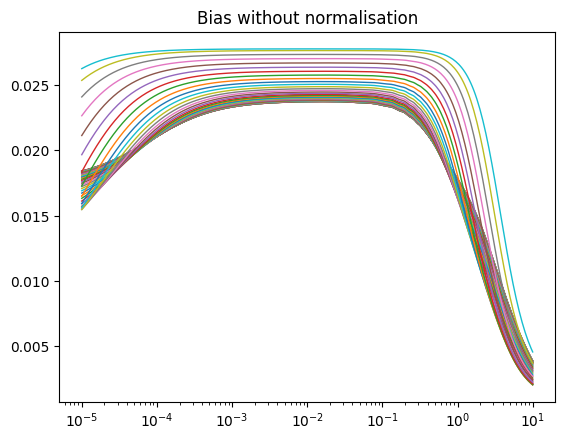

In [6]:
for i in range(len(bias_sq)):
    plt.semilogx(k_vector_over_times_h, bias_sq[i], lw=1)
plt.title('Bias without normalisation')
plt.show()

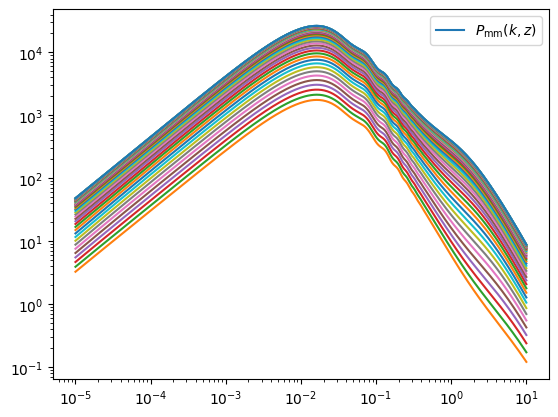

In [7]:
bias_sq /= bias_sq[:,0][:,None]

# plt.loglog(k_vector_over_times_h, (hmcode_pofk[0, 0]*bias_sq)[0,:], label = r"$P_\mathrm{ee}(k,z)=b^2_\mathrm{e} P_\mathrm{mm}(k,z)$") 
# plt.loglog(k_vector_over_times_h, (hmcode_pofk[0, 0]*np.sqrt(bias_sq))[0,:], label = r"$P_\mathrm{me}(k,z)=b_\mathrm{e} P_\mathrm{mm}(k,z)$")
plt.loglog(k_vector_over_times_h, (hmcode_pofk[0, 0])[0,:], label=r"$P_\mathrm{mm}(k,z)$")
for i in range(len(zet_interp)):
    plt.loglog(k_vector_over_times_h, hmcode_pofk[0, 0,::-1][i]) #, label=f"{zet_interp[i]}"

plt.legend()
plt.show()

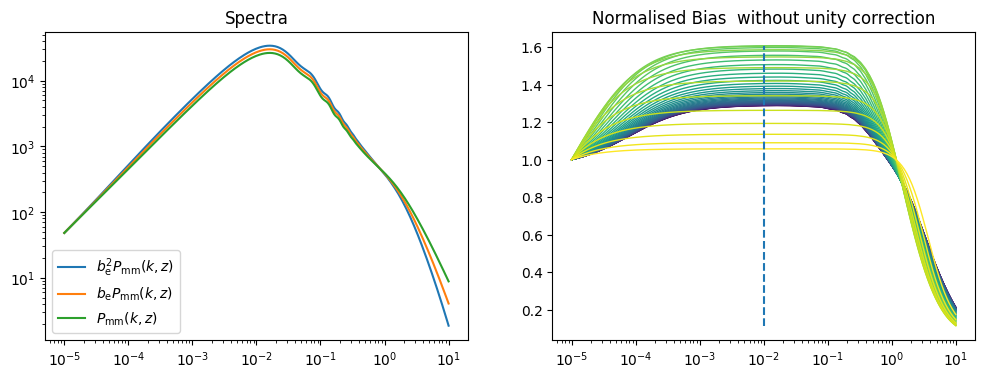

In [9]:
fig, (ax1,ax2) = plt.subplots(1,2, sharex=True, figsize=(12,4))

#Spectras
ax1.loglog(k_vector_over_times_h, (hmcode_pofk[0, 0]*bias_sq)[0,:], label = r"$b^2_\mathrm{e} P_\mathrm{mm}(k,z)$") 
ax1.loglog(k_vector_over_times_h, (hmcode_pofk[0, 0]*np.sqrt(bias_sq))[0,:], label = r"$b_\mathrm{e} P_\mathrm{mm}(k,z)$")
ax1.loglog(k_vector_over_times_h, (hmcode_pofk[0, 0])[0,:], label=r"$P_\mathrm{mm}(k,z)$")
ax1.set_title("Spectra")
ax1.legend()

#Biases
colors = plt.cm.viridis(np.linspace(0, 1, len(bias_sq)))
for i in range(len(bias_sq)):
    ax2.plot(k_vector_over_times_h, bias_sq[i], lw=1, color=colors[i])
ax2.vlines(1e-2, np.min(bias_sq), np.max(bias_sq), linestyle='--')
ax2.set_title("Normalised Bias  without unity correction")

# plt.savefig('Spctra and bias without bias correction.jpg', dpi=300)
plt.show()

Manually setting the bias to unity for $k<10^{-2}h/\mathrm{Mpc}$. Problem is the rough transition. We want a smooth transition. That's why we use two different methods for smoothening.

### Method 1: 
Set the values of biases for $k<10^{-2}h/\mathrm{Mpc}$ to the value at $k=10^{-2}h/\mathrm{Mpc}$ and normalise.

In [10]:
#getting the minimum value of k for the range [1e-2, 2e-2]
k = np.copy(k_vector_over_times_h)
k_at_minus_2 = k[np.logical_and(k>1e-2, k<2e-2)].min() 

In [11]:
#assigning all the values for k<1e-2 to the value at k=1e-2
bias_sq_met1 = np.copy(bias_sq) #bias for method 1
bias_sq_met1[:, k<1e-2] = bias_sq_met1[:, np.where(k==k_at_minus_2)].reshape(50,1)

#normalise
bias_sq_norm_met1 = bias_sq_met1/bias_sq_met1[:,0][:,None]

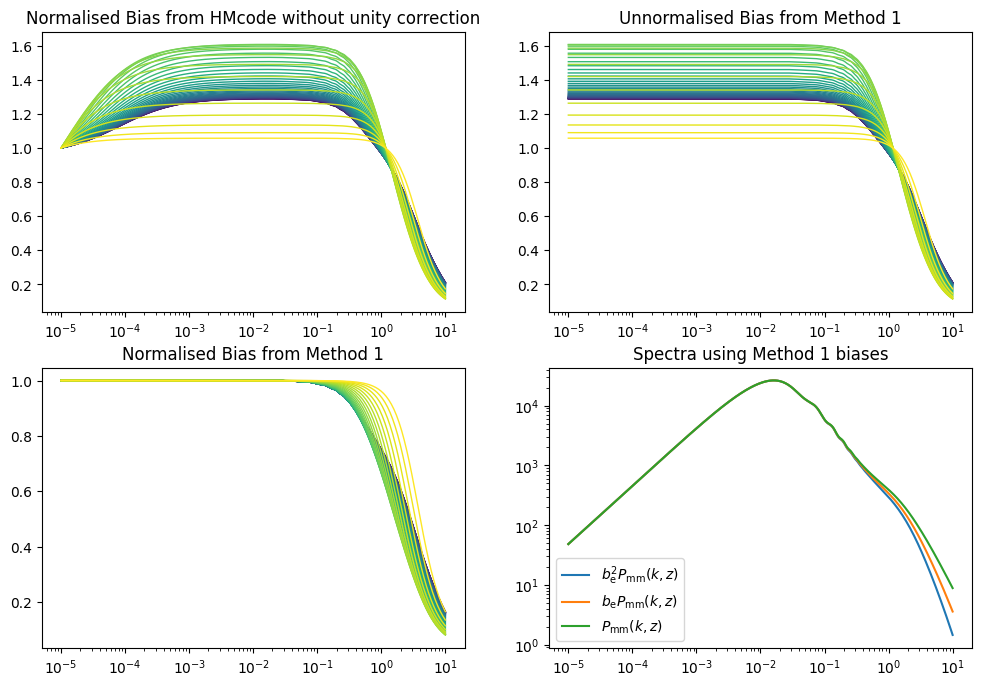

In [12]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs[0, 0].set(title='Normalised Bias from HMcode without unity correction', xscale='log')
axs[0, 1].set(title='Unnormalised Bias from Method 1', xscale='log')
axs[1, 0].set(title='Normalised Bias from Method 1', xscale='log')

for i in range(len(bias_sq)):
    axs[0, 0].plot(k_vector_over_times_h, bias_sq[i], lw=1, color=colors[i])
    axs[0, 1].plot(k_vector_over_times_h, bias_sq_met1[i], lw=1, color=colors[i])
    axs[1, 0].plot(k_vector_over_times_h, bias_sq_norm_met1[i], lw=1, color=colors[i])

axs[1, 1].loglog(k_vector_over_times_h, (hmcode_pofk[0, 0]*bias_sq_norm_met1)[0,:], label = r"$b^2_\mathrm{e} P_\mathrm{mm}(k,z)$") 
axs[1, 1].loglog(k_vector_over_times_h, (hmcode_pofk[0, 0]*np.sqrt(bias_sq_norm_met1))[0,:], label = r"$b_\mathrm{e} P_\mathrm{mm}(k,z)$")
axs[1, 1].loglog(k_vector_over_times_h, (hmcode_pofk[0, 0])[0,:], label=r"$P_\mathrm{mm}(k,z)$")
axs[1, 1].set(title="Spectra using Method 1 biases", xscale='log')
axs[1, 1].legend()
# plt.savefig('Spectra and bias from Method 1 full.jpg', dpi=300)
plt.show()

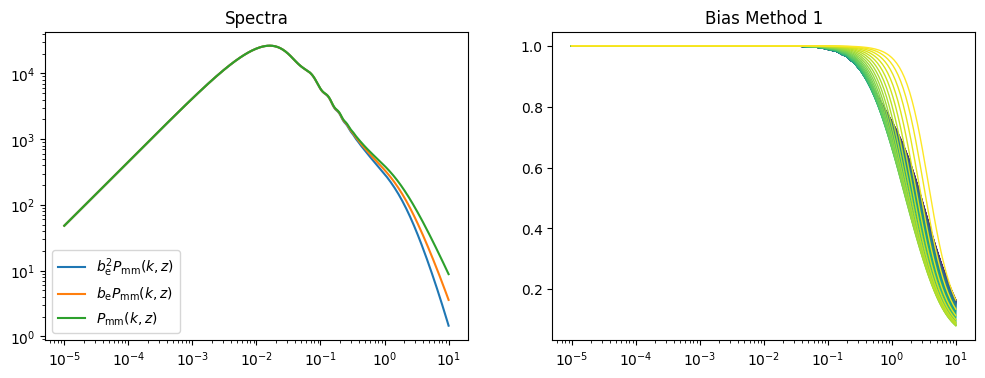

In [13]:
fig, (ax1,ax2) = plt.subplots(1,2, sharex=True, figsize=(12,4))

#Spectras
ax1.loglog(k_vector_over_times_h, (hmcode_pofk[0, 0]*bias_sq_norm_met1)[0,:], label = r"$b^2_\mathrm{e} P_\mathrm{mm}(k,z)$") 
ax1.loglog(k_vector_over_times_h, (hmcode_pofk[0, 0]*np.sqrt(bias_sq_norm_met1))[0,:], label = r"$b_\mathrm{e} P_\mathrm{mm}(k,z)$")
ax1.loglog(k_vector_over_times_h, (hmcode_pofk[0, 0])[0,:], label=r"$P_\mathrm{mm}(k,z)$")
ax1.set_title("Spectra")
ax1.legend()

#Biases
colors = plt.cm.viridis(np.linspace(0, 1, len(bias_sq)))
for i in range(len(bias_sq)):
    ax2.plot(k_vector_over_times_h, bias_sq_norm_met1[i], lw=1, color=colors[i])
# ax2.vlines(1e-2, np.min(bias_sq), np.max(bias_sq), linestyle='--')
ax2.set_title("Bias Method 1")

# plt.savefig('Spctra and normalised bias with correction from Method 1.jpg', dpi=300)
plt.show()

### Method 2 
Set all values of biases for $k<10^{-2}h/\mathrm{Mpc}$ equal to Unity and then fit use a smooth transition

In [14]:
k = np.copy(k_vector_over_times_h)
bias_sq_met2 = np.copy(bias_sq)
bias_sq_met2[:, k<1e-2] = 1

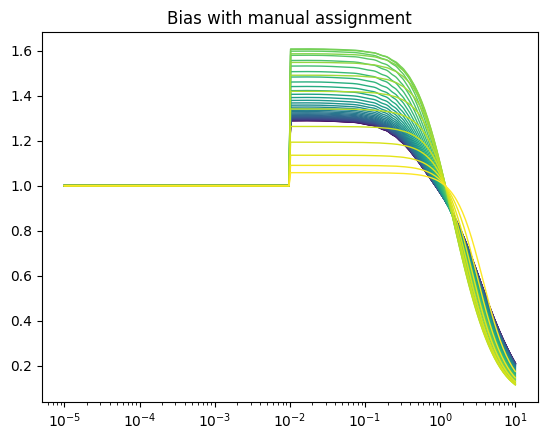

In [15]:
for i in range(len(bias_sq)):
    plt.semilogx(k_vector_over_times_h, bias_sq_met2[i], lw=1, color=colors[i])
plt.title('Bias with manual assignment')
plt.show()

#### Interpolation

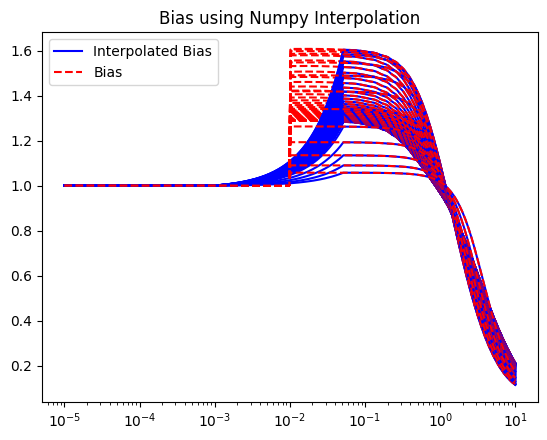

In [16]:
mask_boundary = [1e-3, 5e-2]
bias_using_interpolation = []

#mask for the interpolation area
interpolation_mask = np.where(np.logical_and(k>1e-3, k<5e-2))
k_interpol = k[interpolation_mask]

for i in range(len(bias_sq)):
    
#Interpolation part
    bias_interpol_ = bias_sq_met2[:, interpolation_mask][i]
    
    #mask for the data used for interpolation
    
    data_mask = np.where(np.logical_or(k<1e-3, k>5e-2))
    bias_data_mask = bias_sq_met2[i][data_mask]
    k_data_mask = k[data_mask]
    
    bias_interpol = np.interp(k_interpol, k_data_mask, bias_data_mask)
    
    # plt.semilogx(k_interpol, bias_interpol)
    # plt.semilogx(k_interpol, bias_interpol_[0], color='r')
    
    bias_sq_norm_met2_interpolation = np.copy(bias_sq_met2[i])
    bias_sq_norm_met2_interpolation[interpolation_mask] = bias_interpol
    bias_using_interpolation.append(bias_sq_norm_met2_interpolation)

    # plt.semilogx(k, , color ='b', label='Interpolated Bias'if i == 0 else None)
    plt.semilogx(k, bias_sq_norm_met2_interpolation, color ='b', label='Interpolated Bias'if i == 0 else None)
    plt.semilogx(k, bias_sq_met2[i], color='r', linestyle='--', label='Bias'if i == 0 else None)
plt.legend()
plt.title('Bias using Numpy Interpolation')
# plt.savefig('Bias using Numpy Interpolation.jpg', dpi=300)
plt.show()

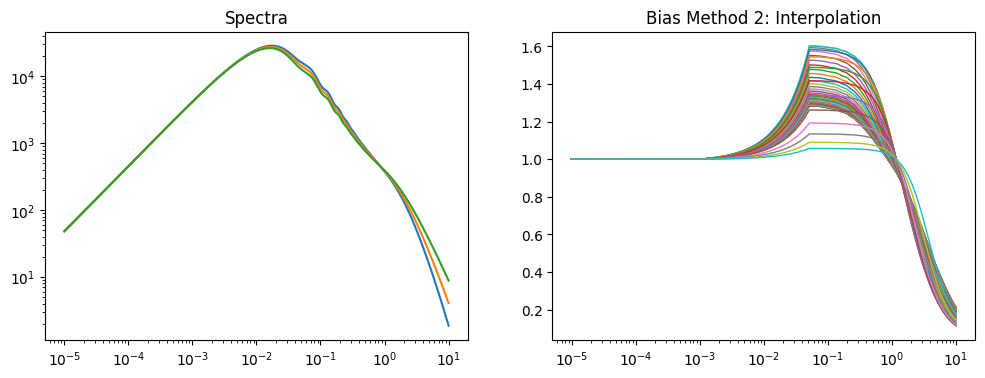

In [17]:
fig, (ax1,ax2) = plt.subplots(1,2, sharex=True, figsize=(12,4))
ax1.set(title = 'Spectra', xscale='log')
ax2.set(title = 'Bias Method 2: Interpolation', xscale='log')
                              
#mask for the interpolation area
# interpolation_mask = np.where(np.logical_and(k>1e-3, k<5e-2))
# k_interpol = k[interpolation_mask]

for i in range(len(bias_sq)):
    
#Interpolation part
    bias_interpol_ = bias_sq_met2[:, interpolation_mask][i]
    
    #mask for the data used for interpolation
    
    data_mask = np.where(np.logical_or(k<1e-3, k>5e-2))
    bias_data_mask = bias_sq_met2[i][data_mask]
    k_data_mask = k[data_mask]
    
    bias_interpol = np.interp(k_interpol, k_data_mask, bias_data_mask)
    
    bias_sq_norm_met2_interpolation = np.copy(bias_sq_met2[i])
    bias_sq_norm_met2_interpolation[interpolation_mask] = bias_interpol
    colors = plt.cm.viridis(np.linspace(0, 1, len(bias_sq)))
    ax2.plot(k, bias_sq_norm_met2_interpolation, lw=1)
    # ax2.vlines(1e-2, np.min(bias_sq), np.max(bias_sq), linestyle='--')

#Spectras
ax1.loglog(k_vector_over_times_h, (hmcode_pofk[0, 0]*bias_using_interpolation)[0,:], label = r"$b^2_\mathrm{e} P_\mathrm{mm}(k,z)$") 
ax1.loglog(k_vector_over_times_h, (hmcode_pofk[0, 0]*np.sqrt(bias_using_interpolation))[0,:], label = r"$b_\mathrm{e} P_\mathrm{mm}(k,z)$")
ax1.loglog(k_vector_over_times_h, (hmcode_pofk[0, 0])[0,:], label=r"$P_\mathrm{mm}(k,z)$")


plt.savefig('Spctra and interpolated bias from Method 2.jpg', dpi=300)
plt.show()

#### Gaussian filter

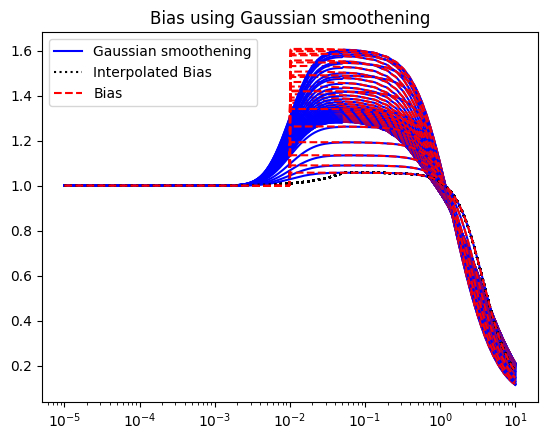

In [18]:
import scipy.ndimage
bias_using_gauss = []

for i in range(len(bias_sq)):
    smoothed_bias = scipy.ndimage.gaussian_filter(bias_sq_met2[i], sigma=13, mode='wrap') #sigma=10-13 works best  #wrap: abcd|abcd|abcd at borders
    bias_gauss = smoothed_bias[interpolation_mask]
    
    # plt.semilogx(k, smoothed_bias)
    # plt.semilogx(k_interpol, bias_gauss)
    
    bias_sq_norm_met2_gauss = np.copy(bias_sq_met2[i])
    bias_sq_norm_met2_gauss[interpolation_mask] = bias_gauss
    bias_using_gauss.append(bias_sq_norm_met2_gauss)
    
    plt.semilogx(k, bias_sq_norm_met2_gauss, color ='b', label='Gaussian smoothening'if i == 0 else None)
    plt.semilogx(k, bias_sq_norm_met2_interpolation, color ='black',  linestyle=':', label='Interpolated Bias'if i == 0 else None)
    plt.semilogx(k, bias_sq_met2[i], color='r', linestyle='--', label='Bias'if i == 0 else None)

plt.title('Bias using Gaussian smoothening')
# plt.savefig('Bias using Gaussian smoothening.jpg', dpi=300)
plt.legend()
plt.show()

In [19]:
np.shape(bias_using_gauss)

(50, 300)

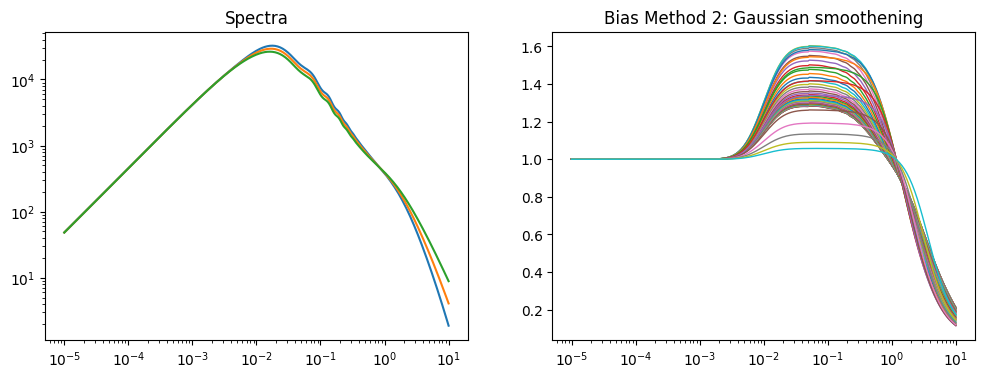

In [20]:
fig, (ax1,ax2) = plt.subplots(1,2, sharex=True, figsize=(12,4))
ax1.set(title = 'Spectra', xscale='log')
ax2.set(title = 'Bias Method 2: Gaussian smoothening', xscale='log')
                              
#mask for the interpolation area
# interpolation_mask = np.where(np.logical_and(k>1e-3, k<5e-2))
# k_interpol = k[interpolation_mask]

for i in range(len(bias_sq)):
    
#Gaussian part

    smoothed_bias = scipy.ndimage.gaussian_filter(bias_sq_met2[i], sigma=13, mode='wrap') #sigma=10-13 works best  #wrap: abcd|abcd|abcd at borders
    bias_gauss = smoothed_bias[interpolation_mask]
    
    # plt.semilogx(k, smoothed_bias)
    # plt.semilogx(k_interpol, bias_gauss)
    
    bias_sq_norm_met2_gauss = np.copy(bias_sq_met2[i])
    bias_sq_norm_met2_gauss[interpolation_mask] = bias_gauss
    
    ax2.plot(k, bias_sq_norm_met2_gauss, label='Gaussian smoothening'if i == 0 else None, lw=1)
    #ax2.plot(k, bias_sq_norm_met2_interpolation, color ='black',  linestyle=':', label='Interpolated Bias'if i == 0 else None)
    # ax2.plot(k, bias_sq_met2[i], color='r', linestyle='--', label='Bias'if i == 0 else None, lw=.8)
    # ax2.legend()

#Spectras
ax1.loglog(k_vector_over_times_h, (hmcode_pofk[0, 0]*bias_using_gauss)[0,:], label = r"$b^2_\mathrm{e} P_\mathrm{mm}(k,z)$") 
ax1.loglog(k_vector_over_times_h, (hmcode_pofk[0, 0]*np.sqrt(bias_using_gauss))[0,:], label = r"$b_\mathrm{e} P_\mathrm{mm}(k,z)$")
ax1.loglog(k_vector_over_times_h, (hmcode_pofk[0, 0])[0,:], label=r"$P_\mathrm{mm}(k,z)$")


plt.savefig('Spctra and Gaussian smoothed bias from Method 2.jpg', dpi=300)
plt.show()

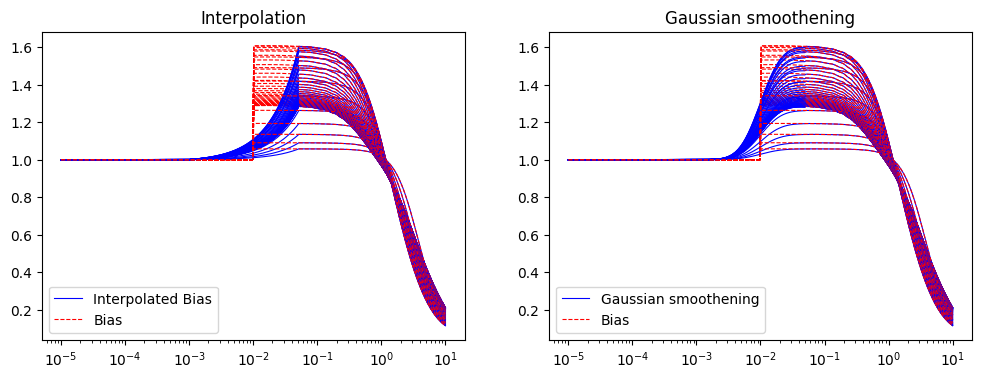

In [21]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,4))
ax1.set(title = 'Interpolation', xscale='log')
ax2.set(title = 'Gaussian smoothening', xscale='log')
                              
#mask for the interpolation area
interpolation_mask = np.where(np.logical_and(k>1e-3, k<5e-2))
k_interpol = k[interpolation_mask]

for i in range(len(bias_sq)):
    
#Interpolation part
    bias_interpol_ = bias_sq_met2[:, interpolation_mask][i]
    
    #mask for the data used for interpolation
    
    data_mask = np.where(np.logical_or(k<1e-3, k>5e-2))
    bias_data_mask = bias_sq_met2[i][data_mask]
    k_data_mask = k[data_mask]
    
    bias_interpol = np.interp(k_interpol, k_data_mask, bias_data_mask)
    
    bias_sq_norm_met2_interpolation = np.copy(bias_sq_met2[i])
    bias_sq_norm_met2_interpolation[interpolation_mask] = bias_interpol
    
    ax1.plot(k, bias_sq_norm_met2_interpolation, color ='b', label='Interpolated Bias'if i == 0 else None, lw=.8)
    ax1.plot(k, bias_sq_met2[i], color='r', linestyle='--', label='Bias'if i == 0 else None, lw=.8)
    ax1.legend(loc='lower left')

#Gaussian part

    smoothed_bias = scipy.ndimage.gaussian_filter(bias_sq_met2[i], sigma=13, mode='wrap') #sigma=10-13 works best  #wrap: abcd|abcd|abcd at borders
    bias_gauss = smoothed_bias[interpolation_mask]
    
    # plt.semilogx(k, smoothed_bias)
    # plt.semilogx(k_interpol, bias_gauss)
    
    bias_sq_norm_met2_gauss = np.copy(bias_sq_met2[i])
    bias_sq_norm_met2_gauss[interpolation_mask] = bias_gauss
    
    ax2.plot(k, bias_sq_norm_met2_gauss, color ='b', label='Gaussian smoothening'if i == 0 else None, lw=.8)
    #ax2.plot(k, bias_sq_norm_met2_interpolation, color ='black',  linestyle=':', label='Interpolated Bias'if i == 0 else None)
    ax2.plot(k, bias_sq_met2[i], color='r', linestyle='--', label='Bias'if i == 0 else None, lw=.8)
    ax2.legend()

plt.savefig('Interpolation vs Gaussian.jpg', dpi=300)
plt.show()

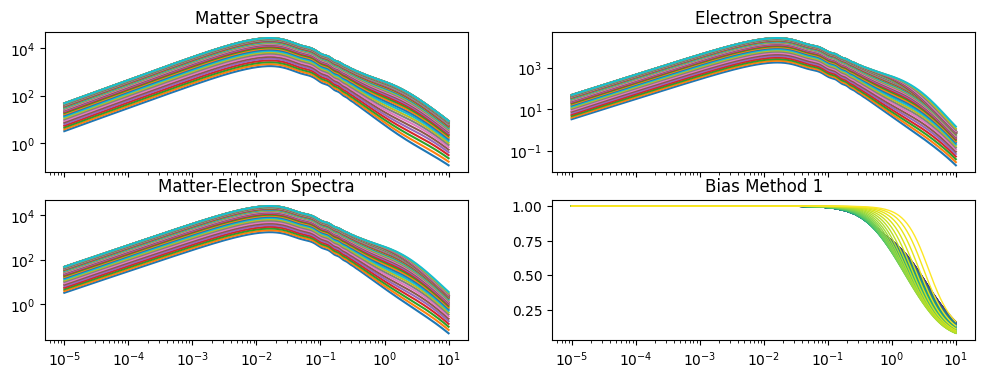

In [22]:
fig, axs = plt.subplots(2,2, sharex=True, figsize=(12,4))

#Spectras
# ax1.loglog(k_vector_over_times_h, (hmcode_pofk[0, 0]*bias_sq_norm_met1)[0,:], label = r"$b^2_\mathrm{e} P_\mathrm{mm}(k,z)$") 
# ax1.loglog(k_vector_over_times_h, (hmcode_pofk[0, 0]*np.sqrt(bias_sq_norm_met1))[0,:], label = r"$b_\mathrm{e} P_\mathrm{mm}(k,z)$")
# ax1.loglog(k_vector_over_times_h, (hmcode_pofk[0, 0])[0,:], label=r"$P_\mathrm{mm}(k,z)$")

# ax1.legend()


for i in range(len(zet_interp)):
    axs[0,0].loglog(k_vector_over_times_h, hmcode_pofk[0, 0,::-1][i])
    axs[0,0].set_title("Matter Spectra")

    axs[0,1].loglog(k_vector_over_times_h, hmcode_pofk[0, 0,::-1][i]*bias_sq_norm_met1[i])
    axs[0,1].set_title("Electron Spectra")

    axs[1,0].loglog(k_vector_over_times_h, hmcode_pofk[0, 0,::-1][i]*np.sqrt(bias_sq_norm_met1)[i])
    axs[1,0].set_title("Matter-Electron Spectra")


#Biases
colors = plt.cm.viridis(np.linspace(0, 1, len(bias_sq)))
for i in range(len(bias_sq)):
    axs[1,1].plot(k_vector_over_times_h, bias_sq_norm_met1[i], lw=1, color=colors[i])
# ax2.vlines(1e-2, np.min(bias_sq), np.max(bias_sq), linestyle='--')
axs[1,1].set_title("Bias Method 1")

# plt.savefig('Spctra and normalised bias with correction from Method 1.jpg', dpi=300)
plt.show()